In [20]:
import numpy as np
import networkx as nx
import scipy.integrate as odeint
import kuramoto as kr
import matplotlib as mpl
import matplotlib.pyplot as plt
import math 
import csv
from colour import Color 


In [21]:

# class Oscillator:
#     def __init__(self,nat):
#         self.nat = nat  # nat freq of oscillator
        
#     def update(self,int): # function takes in a interaction 
''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''
def rgb_spectrum_line(value): # NEEDS OPACITY AND TUNING 
    if value == 0: 
        rgb = np.array([1.0,1.0,1.0]) # white 
    elif value < 0:
        rgb = abs(value)*np.array([1.0,0.0,0.0]) # yellow if < 0 
    else:
        rgb = abs(value)*np.array([0.0,0.0,1.0]) # blue >0
    return rgb
        

class Net:
    def __init__(self,Adj,n,k,dt,var,mean):
        self.Adj = Adj#Adjacency with weighted and dircetional couplings
        self.rtn = n
        self.n = n**2
        self.dt = dt
        self.k = k
       
        
        self.space = [] #3 dimensional vectors in node based vector. 
        # NEEDS GENERATOR
        self.state = np.random.uniform(-2*np.pi,2*np.pi,(n,1)) # nx1 vector of current oscillator  states
        print('init state = {}'.format(self.state))
        self.nats =  2*np.pi*dt*np.random.normal(mean,var,(n,1)) # Vector of natural freqs, currently all unity for simplicity. 
        print('init nats = {}'.format(self.nats))
        self.I = np.zeros((n,1))
        self.noise_A = 0.5*np.sqrt(dt)
        self.graph = nx.from_numpy_array(self.Adj)
        self.pos = nx.kamada_kawai_layout(self.graph)
    
    def Mesh(self):
        
        x = np.linspace(0,100,self.rtn)
        y = np.linspace(0,100,self.rtn)
        xv,yv = np.meshgrid(x,y,indexing = 'ij')
        
        # Build Adj for grid 
        # Check all 4 directions
        self.Adj = np.zeros((self.rtn,self.rtn)) # RESET ADJ
        for i in range(self.rtn):
            for j in range(self.rtn):
                self.pos[i,j] = [xv[i,j],yv[i,j]] # update position for plotting
                if i - 1 >= 0:
                    self.Adj[i-1,j] = self.k
                if i + 1 < self.rtn: 
                    self.Adj[i+1,j] = self.k
                if j - 1 >= 0:
                    self.Adj[i,j-1] = self.k  
                if j + 1 < self.rtn: 
                    self.Adj[i,j+1] = self.k
        print(f"Grid{self.Adj}")                 
        # Couple if exist. 
        
        
    def Gauss_Space(self,space_mean,space_var):
        self.space = np.random.normal(space_mean,space_var,(self.n,2))
        self.pos = self.space
 
    def distribute_adj(self,distribution):
        if distribution == 'uni':
            self.Adj = self.Adj * np.random.uniform(-1,1,self.Adj.shape)

    def R2Connect(self):
        for i in range(self.n-1):
            for j in range(i+1,self.n): 
                    if j != i: 
                        xi = self.space[i,:]
                        xj = self.space[j,:]
                        r2 = (np.linalg.norm(xi-xj))**2
                        self.Adj[i,j] = self.k/(1 + r2)
                        self.Adj[j,i] = self.k/(1 + r2)
        
    def Connect(self,a,P_inhib):
        # -a is power law exponent
        for i in range(self.n-1):
            for j in range(i+1,self.n): 
                if j != i:
                    pool = np.zeros([10000,1])
                    inhib_pool = np.ones([10000,1])
                    xi = self.space[i,:]
                    xj = self.space[j,:]
                    s = np.abs(xi-xj)
                    mag = np.sqrt(s[0]**2 + s[1]**2)# + s[2]**2 )
                    prob_connect = 1/(mag**a+1) # connection law. +1 is offset to normalise ## CHANGE to control connectivity
                    connect_num = np.round(len(pool)*prob_connect)
                    pool[1:int(connect_num)] = 1
                    np.random.shuffle(pool)
                    inhib_num = np.round(len(pool)*P_inhib)
                    pool[1:int(inhib_num)] = -1
                    np.random.shuffle(inhib_pool)
                    self.Adj[i,j] = (1/mag)*pool[np.random.randint(0,len(pool))]*inhib_pool[np.random.randint(0,len(pool))]
                    self.Adj[j,i] = (1/mag)*pool[np.random.randint(0,len(pool))]*inhib_pool[np.random.randint(0,len(pool))]
                else:
                    continue
        
    def Update(self):
    
        for i in range(self.n):
            I_n = 0
            for j in range(self.n):
                if self.Adj[i,j] != 0:
                    I_n += self.Adj[i,j]*np.sin(self.state[j] - self.state[i])*self.dt # update value of phase
                # if i != j:    
                #     xi = self.space[i,:]
                #     xj = self.space[j,:]
                #     r2 = (np.linalg.norm(xi-xj))**2
                #     self.Adj[i,j] += np.cos(self.state[j] - self.state[i])*self.dt/(1+r2) # update coupling
                ## SECOND ORDER UPDATING
                # if self.Adj[i,j] != 0: # if not itself
                #     I_n += np.sin(self.state[j] - self.state[i])*self.dt
            self.I[i] = I_n*1/self.n
        #print('pre state = {}'.format(self.state))
        self.state += self.nats + self.I  #+ self.noise_A*np.random.randn(self.n,1)
        
        #print('post state = {}'.format(self.state))
        
    def View(self):
        self.graph = nx.from_numpy_array(self.Adj)
        #edge colours should be realted to normalised weights 
        
        #node colours should be current phase
        color_map = []
        # for i in range(self.n):
        #     color_map.append(cyclic_rgb(self.state[i]))
        # print(color_map)  
        Order = np.arange(0, self.n-1, 2)
        Order = np.hstack((Order, np.arange(self.n-1, 0, -2)))
        
        fig, axs = plt.subplots(1, 2, figsize=(15, 8))
        # ax = axs[0]
        # # colormap(jet)
        # ax.pcolormesh(self.Adj[Order, :][:, Order],cmap=mpl.colormaps['Spectral'])

        # ax.set_xlabel('Nodes')
        # ax.set_ylabel('Nodes')
        # ax.set_title('Coupling Matrix')
        # ax.axis('square')
        # red = Color("red")
        # colors = list(red.range_to(Color("green"),10))
        # #nx.draw(self.graph,node_color=color_map,pos=self.pos) # BROKEN WITH EVOLUTIONS 
        
        
        # ax = axs[1]
        # normalise weights
        norm_adj = np.zeros_like(self.Adj) 
        signed_norm_adj = np.zeros_like(self.Adj) 
        for i in range(0,self.n):
            for j in range(0,self.n):    
                norm_adj[i,j] = (abs(self.Adj[i,j]) - abs(self.Adj).min())/(abs(self.Adj).max() - abs(self.Adj).min())*(1)
            signed_norm_adj = norm_adj*np.sign(self.Adj)
        #print(norm_adj)
        for i in range(0,self.n):
            
            for j in range(i,self.n):
                print(rgb_spectrum_line(norm_adj[i,j]))
                plt.plot([self.pos[i][0],self.pos[j][0]],[self.pos[i][1],self.pos[j][1]],linestyle = '-',color = rgb_spectrum_line(signed_norm_adj[i,j]),alpha = norm_adj[i,j])
            plt.scatter(self.pos[i][0],self.pos[i][1])
            
            
        # ax = axs[2]
        # pos_phase = [np.cos(self.state),np.sin(self.state)]
        # for i in range(0,self.n):
        #     for j in range(0,self.n):    
        #         norm_adj[i,j] = (abs(self.Adj[i,j]) - abs(self.Adj).min())/(abs(self.Adj).max() - abs(self.Adj).min())*(1)
        #     signed_norm_adj = norm_adj*np.sign(self.Adj)
        # #print(norm_adj)
        # for i in range(0,self.n):
            
        #     for j in range(i,self.n):
        #         print(rgb_spectrum_line(norm_adj[i,j]))
        #         plt.plot([pos_phase[i][0],pos_phase[j][0]],[pos_phase[i][1],pos_phase[j][1]],linestyle = '-',color = rgb_spectrum_line(signed_norm_adj[i,j]),alpha = norm_adj[i,j])
        #     plt.scatter(pos_phase[i][0],pos_phase[i][1])
        
        
                
''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''       
        # print('th0 {}'.format(self.state))
        # self.sins = np.sin(np.subtract.outer(self.state, np.transpose(self.state))) #sines of differences
        # #print(np.outer(self.state, np.transpose(self.state)))
        # #print('sin {}'.format(np.sin(np.subtract.outer(self.state, np.transpose(self.state)))))
        
        # #print('sins {}'.format(self.sins))
        # self.I = np.sum(np.multiply(self.Adj,self.sins), axis=0) # I is sum of contributions on each oscillator
        # print(np.multiply(self.Adj,self.sins))
        # print('I {}'.format(self.I))
        # self.state += self.nats + self.I
        # #print('nat = {}'.format(self.nats*dt))
        # #print('th1 {}'.format(self.state))
       
''' 
Can't interact with adjacency here 
''' 
    # def theta_dot(self,t,angles_vec):
    #     angles_i, angles_j = np.meshgrid(angles_vec, angles_vec)
    #     I = self.Adj* np.sin(angles_j - angles_i)
    #     dxdt = self.nats + I.sum(axis=0)
    #     return dxdt
    
    # def Run(self,dt,T):
    #     t = np.linspace(0, self.T, int(self.T/self.dt))
    #     timeseries = odeint(self.derivative, self.state, t)
    #     return timeseries
        
        


" \nCan't interact with adjacency here \n"

[  0.          11.11111111  22.22222222  33.33333333  44.44444444
  55.55555556  66.66666667  77.77777778  88.88888889 100.        ]
[  0.          11.11111111  22.22222222  33.33333333  44.44444444
  55.55555556  66.66666667  77.77777778  88.88888889 100.        ]
(20, 10)


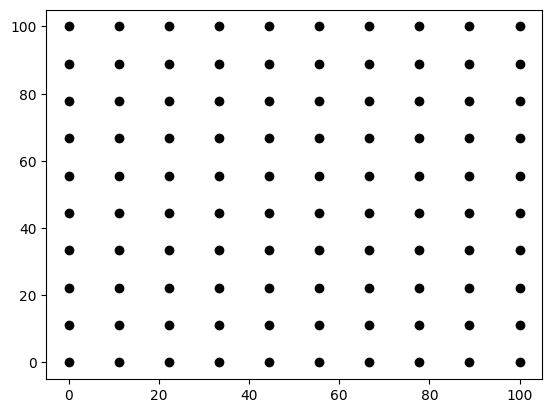

In [22]:
x = np.linspace(0,100,10)
y = np.linspace(0,100,10)
print(x)
print(y)
xv,yv = np.meshgrid(x,y,indexing = 'xy')
print(np.shape(np.append(xv,yv,axis = 0)))
plt.plot(xv, yv, marker='o', color='k', linestyle='none')

plt.show()



init state = [[-1.21998189]
 [-5.03051866]
 [ 4.30474   ]
 [ 1.45897438]
 [ 2.74694851]
 [-3.64388022]
 [ 1.82653799]
 [ 1.92650848]
 [-2.4859706 ]
 [ 5.18308163]
 [-3.73235967]
 [ 3.57447227]
 [-4.12432955]
 [ 2.31545597]
 [-1.31899856]
 [ 1.92410184]
 [-3.54373655]
 [-2.27977208]
 [ 0.70542812]
 [ 3.81500229]
 [-5.17218993]
 [ 4.99672983]
 [-2.21172114]
 [-5.46126538]
 [-3.14438749]
 [ 6.21379265]
 [-0.33728546]
 [ 4.89955131]
 [ 4.22238552]
 [ 2.81956738]
 [-0.40777382]
 [ 1.30471785]
 [ 1.7455455 ]
 [-0.88798896]
 [ 5.19985471]
 [-0.35427973]
 [-4.04678435]
 [-1.20547063]
 [ 2.99714167]
 [-5.93607277]
 [ 0.41084335]
 [-2.12936842]
 [-5.28205404]
 [ 3.34282327]
 [ 4.53219192]
 [-0.99616885]
 [-2.57247067]
 [-3.83154482]
 [-4.22294678]
 [ 5.99718063]
 [-3.18302329]
 [-0.71337188]
 [ 4.93025769]
 [-2.71023257]
 [-1.26448837]
 [-2.82070473]
 [-5.13142452]
 [-3.44003539]
 [ 0.60005435]
 [ 4.90844077]
 [ 2.53108483]
 [ 4.73291849]
 [ 0.04301533]
 [-3.85061145]
 [-5.61024844]
 [-1.3566140

IndexError: index 100 is out of bounds for axis 0 with size 100

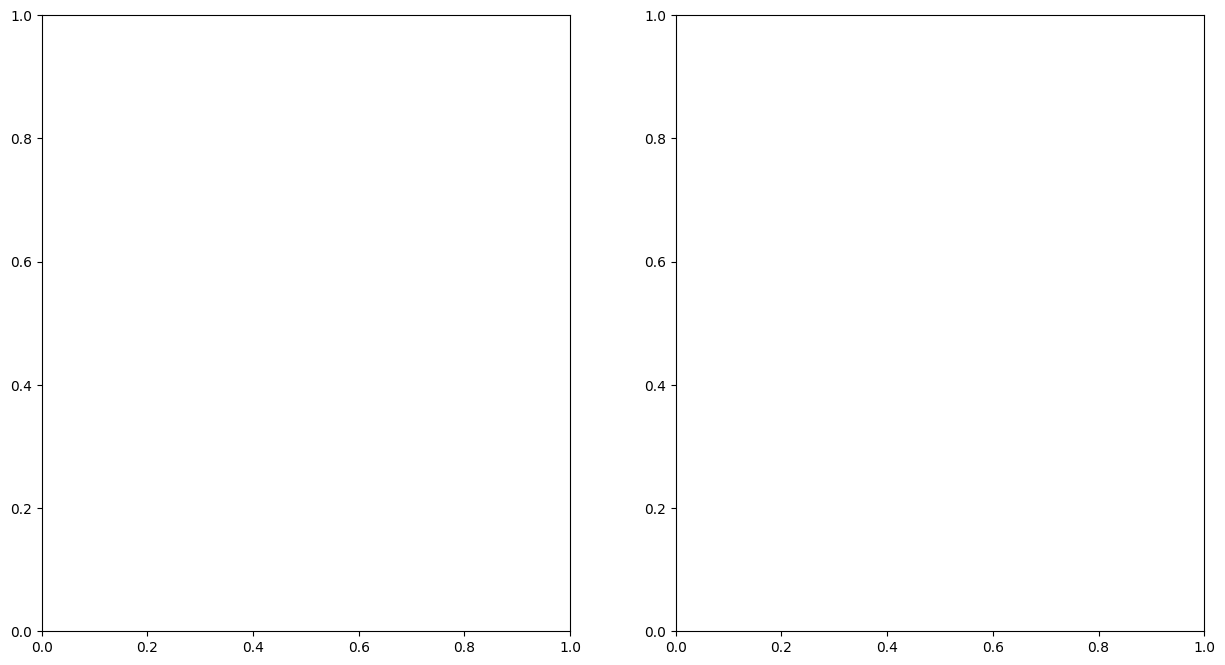

In [23]:
# test = [[0,10],[10,0]] # test adj with linear coupling
# testnet = Net(test,2)
# print(testnet.nats)
N = 100
k = 3
connectivity = 0.3
var,mean = 0.1, 0.5

T = 20
res = 1000
time = np.linspace(0,T,res)
dt = T/res
results = np.zeros((res,N))
evo_adj = np.zeros((N,N,res))
graph_nx = nx.erdos_renyi_graph(n=N, p=connectivity) # p=1 -> all-to-all connectivity
graph = nx.to_numpy_array(graph_nx)*k
# graph = [[0,1,2],
#          [1,0,2],
#          [2,1,0]]
testnet = Net(graph,N,k,dt,var,mean)
# testnet.Gauss_Space(0,1)
# testnet.R2Connect()

testnet.Mesh()

# testnet.distribute_adj('uni')
# print(f'new adj{testnet.Adj}')

testnet.View()

In [ ]:

# T = 1
# res = 30
# time = np.linspace(0,T,res)
# dt = T/res
results = np.zeros((res,N))



for i in range(0,len(time)):
    # print(np.mean(np.sin(testnet.state)))
    # print(np.shape(results))
    # print(np.shape(results[999]))
    results[i,:] = np.sin(testnet.state[:,0]) 
    #evo_adj[:,:,i] = testnet.Adj
    # plt.clf
    # ax.pcolormesh(testnet.Adj[Order, :][:, Order])
    # plt.pause(0.0001)
    # ax.set_xlabel('Nodes')
    # ax.set_ylabel('Nodes')
    # ax.set_title('Coupling Matrix')
    # ax.axis('square')
    testnet.Update()


Text(0, 0.5, 'Order Parameter')

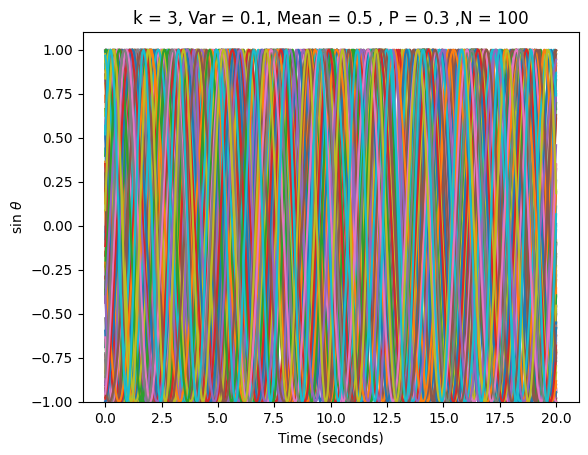

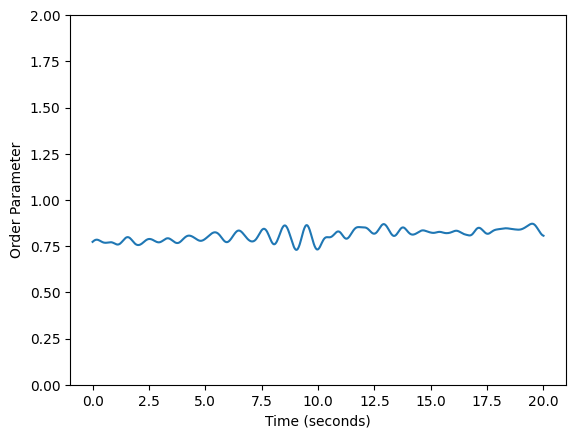

In [ ]:
fig, ax = plt.subplots()
for i in range(N):
    ax.plot(time,results[:,i]) 
    
ax.set_ylim([-1, 1.1])

ax.set_xlabel('Time (seconds)')
ax.set_ylabel(r"sin $\theta $")
ax.set_title(f'k = {k}, Var = {var}, Mean = {mean} , P = {connectivity} ,N = {N}')
fig, ax = plt.subplots()
#print(np.exp(1j*results))
# print(np.mean(np.exp(1j*results)))
OP = np.abs(np.mean(np.exp(1j*results), axis=1))
ax.plot(time, OP)
ax.set_ylim([-0, 2])


ax.set_xlabel('Time (seconds)')
ax.set_ylabel('Order Parameter')


    

[1. 1. 1.]
[0.         0.         0.81291323]
[0.         0.         0.32791557]
[0.         0.         0.95275438]
[0.         0.         0.80760452]
[0.         0.         0.09785745]
[0.         0.         0.14886842]
[0.         0.         0.39365155]
[0.         0.         0.23720144]
[0.         0.         0.49234729]
[0.         0.         0.59255825]
[0.         0.         0.76213147]
[0.         0.         0.63400143]
[0.         0.         0.14031718]
[0.         0.         0.24391489]
[0.         0.         0.25266083]
[0.        0.        0.2165363]
[0.         0.         0.40519764]
[0.         0.         0.36360667]
[0.         0.         0.69521667]
[0.         0.         0.56484352]
[0.         0.         0.25561517]
[0.         0.         0.34680958]
[0.         0.         0.41786155]
[0.         0.         0.85610788]
[0.         0.         0.50248205]
[0.         0.         0.53822184]
[0.         0.         0.57769093]
[0.         0.         0.30563726]
[0.         

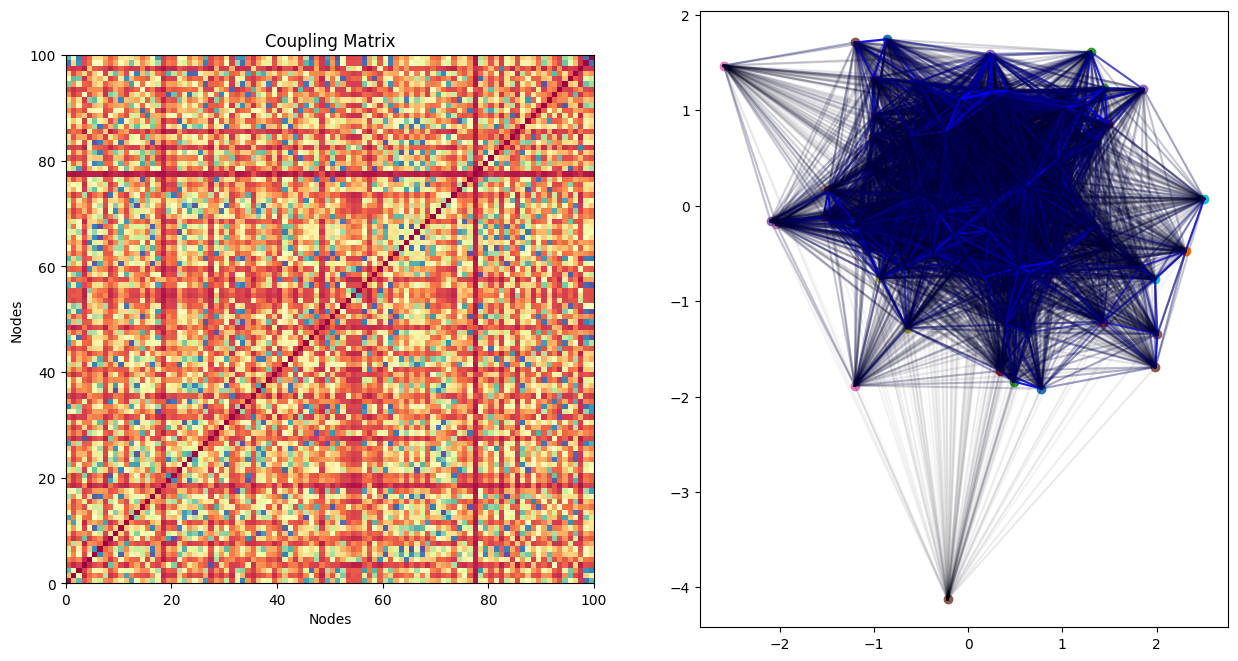

In [ ]:

testnet.View()
#plt.colorbar()

# ax = axs[1]
# X = np.sin(results[:,i])
# FC = (X[:, None, :] * X[None, :, :]).mean(axis=0)
# ax.pcolormesh(FC[Order, :][:, Order])
# ax.set_xlabel('Nodes')
# ax.set_ylabel('Nodes')
# ax.set_title('Correlation Matrix')
# ax.axis('square')
#plt.colorbar()

In [ ]:
print(testnet.Adj)

[[0.         2.43845445 0.98363164 ... 2.46495768 2.49316239 0.98091906]
 [2.43845445 0.         1.39517199 ... 2.98837496 2.58171123 0.67468299]
 [0.98363164 1.39517199 0.         ... 1.31785088 0.94965249 0.44885598]
 ...
 [2.46495768 2.98837496 1.31785088 ... 0.         2.68594948 0.66918264]
 [2.49316239 2.58171123 0.94965249 ... 2.68594948 0.         0.66822665]
 [0.98091906 0.67468299 0.44885598 ... 0.66918264 0.66822665 0.        ]]


# Parameter Sweeps


In [ ]:
## Saving functionality 
'''
Save file is set as N,k,p,var,mean
''' 
f = open(f'C:\\Users\\Harri\\OneDrive - The University of Manchester\\PhD\\Code\\Bayesian\\Python_Compsol\\{N}_{k}_{connectivity}_{mean}_{var}','w')
writer = csv.writer(f)

header = ['t']
for i in range(N):
    header.append(f'theta_{i+1}')
writer.writerow(header)
f.close()





In [ ]:
print(testnet.pos)
print(type(testnet.pos))

[[ 0.16575648  0.73860836]
 [ 0.31185711  1.1957102 ]
 [ 1.3002933   1.61196304]
 [ 0.20181385  0.9586336 ]
 [ 0.56885842  1.01407794]
 [ 1.98733348 -1.69079462]
 [-2.03685777 -0.19231458]
 [-0.76519539 -0.08233227]
 [ 1.51961854 -0.43756198]
 [ 1.07873338  1.18335258]
 [ 0.56177013  0.00993257]
 [-0.30265277  1.04333092]
 [ 0.21215306 -0.01988711]
 [ 0.33963863 -1.73066472]
 [ 1.85904908  1.22134061]
 [-1.07667817 -0.4508008 ]
 [-1.53517994 -0.11316563]
 [ 1.03148171 -0.10917698]
 [-0.41289474 -0.45122739]
 [-0.34412347  1.16120886]
 [ 0.75282415  0.08595188]
 [ 0.52841694 -0.92904447]
 [ 1.44589545  1.23359136]
 [-1.01449688  0.71813546]
 [-0.23231657  0.63985829]
 [ 1.03994128  0.26305124]
 [-0.52358481  0.11974175]
 [-0.07036067 -0.08326791]
 [ 0.47305337 -0.73713003]
 [ 2.5047585   0.07219781]
 [-1.04897708  0.40470044]
 [-0.98666137  0.95276519]
 [ 0.43486931  0.1497694 ]
 [ 0.50937147  0.10197331]
 [ 0.22828425  1.59019346]
 [ 2.00901146 -1.34693468]
 [-2.59426971  1.46907165]
 